In [1]:
import scipy.io
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from scipy.linalg import norm

from tqdm.keras import TqdmCallback
from tqdm.notebook import tqdm
from tensorflow.keras.callbacks import EarlyStopping

from itertools import product
from random import shuffle

from plot_keras_history import plot_history
import matplotlib.pyplot as plt
#import keras_tuner as kt
from keras.models import load_model

import matplotlib
from os.path import exists

from sklearn.metrics import mean_squared_error
import numpy as np

import seaborn as sns
import pandas as pd

import pickle,os

from tensorflow.keras.models import load_model

HYPARAMETER_TUNING = False
TRAIN_MODEL = False
# GOOGLE_COLAB = True



np.random.seed(10)

2024-04-02 15:18:31.480032: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-02 15:18:31.482144: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-02 15:18:31.508064: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-02 15:18:32.103802: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/wubu/miniconda3/envs/heman39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PROJECT_FOLDER = ''

In [3]:
data = scipy.io.loadmat('data.mat')

trainData = data['trainData'].transpose((3,0,1,2))
trainLabels = data['trainLabels'].transpose((3,0,1,2))
valData = data['valData'].transpose((3,0,1,2))
valLabels = data['valLabels'].transpose((3,0,1,2))

In [4]:
print(trainData.shape)
print(valData.shape)


(480, 612, 14, 1)
(32, 612, 14, 1)


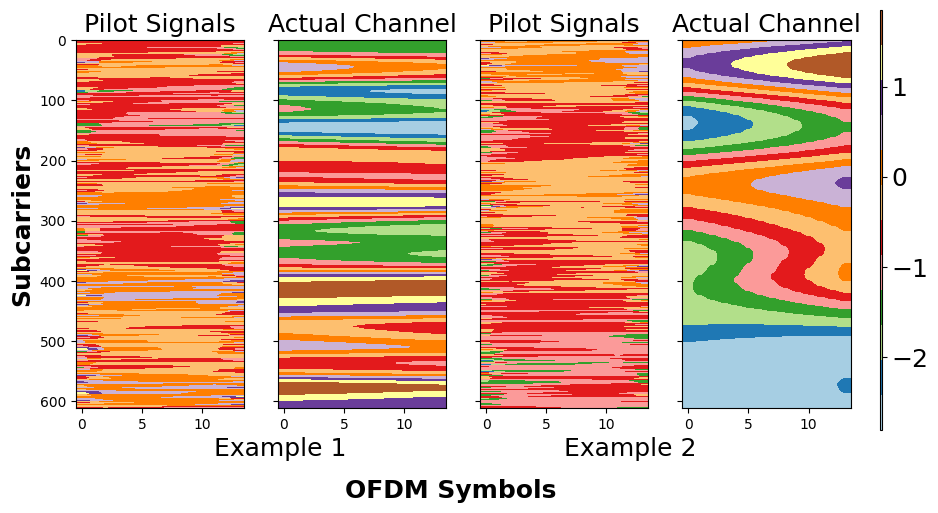

In [5]:
cmap_name = 'Paired'
font_size = 18

rand_idx = np.random.randint(0,valData.shape[0],2)

test_input1 = valData[rand_idx[0]:rand_idx[0]+1,:]
real_output1 = valLabels[rand_idx[0]:rand_idx[0]+1,:]

test_input2 = valData[rand_idx[1]:rand_idx[1]+1,:]
real_output2 = valLabels[rand_idx[1]:rand_idx[1]+1,:]

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10,6), sharey=True)

im1 = ax[0].imshow(test_input1.reshape(612,14), cmap=cmap_name)
ax[0].set_aspect(0.05)
ax[0].set_title('Pilot Signals',fontsize=font_size)

ax[1].imshow(real_output1.reshape(612,14), cmap=cmap_name)
ax[1].set_aspect(0.05)
ax[1].set_title('Actual Channel',fontsize=font_size)

im1 = ax[2].imshow(test_input2.reshape(612,14), cmap=cmap_name)
ax[2].set_aspect(0.05)
ax[2].set_title('Pilot Signals',fontsize=font_size)

ax[3].imshow(real_output2.reshape(612,14), cmap=cmap_name)
ax[3].set_aspect(0.05)
ax[3].set_title('Actual Channel',fontsize=font_size)

ax[0].set_ylabel('Subcarriers',fontsize=font_size, fontweight='bold')
fig.text(0.5,0.05, "OFDM Symbols", ha="center", va="center", fontsize=font_size, fontweight='bold')
fig.text(0.33,0.12, "Example 1", ha="center", va="center", fontsize=font_size, fontweight='normal')
fig.text(0.68,0.12, "Example 2", ha="center", va="center", fontsize=font_size, fontweight='normal')

cbar_ax = fig.add_axes([0.92, 0.152, 0.02, 0.7])
fig.colorbar(im1,cax=cbar_ax)
cbar_ax.set_aspect(50.5)
cbar_ax.tick_params(labelsize=font_size)

plt.show()

In [6]:
def get_model(mult_factor = 1.0, model_name=''):
	model = models.Sequential(name=model_name)
	# selu, softplus, selu
	model.add(layers.Conv2D(int(48*mult_factor), (9, 9), padding='same', activation='selu', input_shape=(612, 14, 1)))
	model.add(layers.Conv2D(int(16*mult_factor), (5, 5), padding='same', activation='softplus'))
	model.add(layers.Conv2D(1, (5, 5),  padding='same', activation='selu'))

	return model

In [7]:
model = get_model(1.0, model_name = 'FL-model')

es_teacher = EarlyStopping(monitor='val_loss',
						  patience=50,
						  verbose=1,
						  restore_best_weights=True,
						  mode='min')

model.compile(optimizer='adam',
					  loss='mse',
					  metrics=['mse'])
# Train and evaluate teacher on data.

hist_model = model.fit(trainData, trainLabels,
			  epochs=1,
			  verbose=0,batch_size=128,
			  callbacks=[es_teacher,TqdmCallback(verbose=1, desc='DL training')],
			  validation_data=(valData, valLabels))


/home/wubu/miniconda3/envs/heman39/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-04-02 15:18:44.319626: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-02 15:18:44.319903: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
DL training: 100%|██████████| 1/1 [00:08<00:00,  8.92s/epo

Restoring model weights from the end of the best epoch: 1.


DL training: 100%|██████████| 1/1 [00:08<00:00,  8.93s/epoch, loss=0.445, mse=0.452, val_loss=0.262, val_mse=0.262]


In [8]:
model.summary()

Model: "FL-model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 612, 14, 48)    │         3,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 612, 14, 16)    │        19,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 612, 14, 1)     │           401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,661 (276.02 KB)

 Trainable params: 23,553 (92.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 47,108 (184.02 KB)

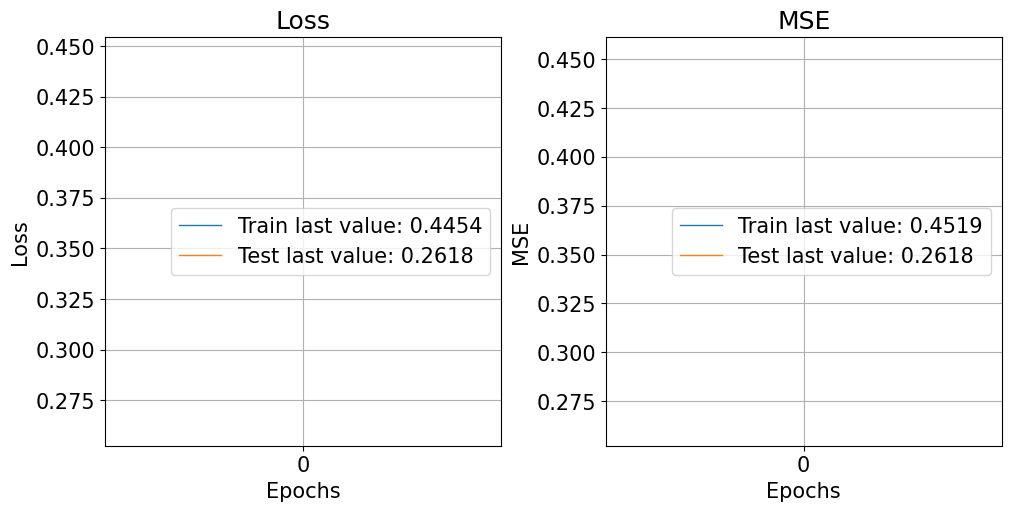

In [9]:

import matplotlib
matplotlib.rcParams.update({'font.size': 15})
plot_history(hist_model.history)
plt.savefig("undefended_training_history.pdf",bbox_inches='tight')
plt.show()


In [10]:
from Pyfhel import Pyfhel, PyPtxt, PyCtxt
import time

In [15]:
def gen_pk():
	HE = Pyfhel()  # Creating empty Pyfhel object
	ckks_params = {
	"scheme": "CKKS",  # can also be 'ckks'
	"n": 2**14,  # Polynomial modulus degree. For CKKS, n/2 values can be
	#  encoded in a single ciphertext.
	#  Typ. 2^D for D in [10, 15]
	"scale": 2**30,  # All the encodings will use it for float->fixed point
	#  conversion: x_fix = round(x_float * scale)
	#  You can use this as default scale or use a different
	#  scale on each operation (set in HE.encryptFrac)
	"qi_sizes": [60, 30, 30, 30, 60],  # Number of bits of each prime in the chain.
	# Intermediate values should be  close to log2(scale)
	# for each operation, to have small rounding errors.
	}
	HE.contextGen(**ckks_params)
	HE.keyGen()
	keys ={}
	keys['HE'] = HE
	keys['con'] = HE.to_bytes_context()
	keys['pk'] = HE.to_bytes_public_key()

	return HE
HE = gen_pk()

In [16]:
# import numpy as np
# from Pyfhel import Pyfhel

# HE = Pyfhel()  # Creating empty Pyfhel object
# ckks_params = {
# 	"scheme": "CKKS",  # can also be 'ckks'
# 	"n": 2**14,  # Polynomial modulus degree. For CKKS, n/2 values can be
# 	#  encoded in a single ciphertext.
# 	#  Typ. 2^D for D in [10, 15]
# 	"scale": 2**30,  # All the encodings will use it for float->fixed point
# 	#  conversion: x_fix = round(x_float * scale)
# 	#  You can use this as default scale or use a different
# 	#  scale on each operation (set in HE.encryptFrac)
# 	"qi_sizes": [60, 30, 30, 30, 60],  # Number of bits of each prime in the chain.
# 	# Intermediate values should be  close to log2(scale)
# 	# for each operation, to have small rounding errors.
# }
# HE.contextGen(**ckks_params)  # Generate context for ckks scheme
# HE.keyGen()  # Key Generation: generates a pair of public/secret keys
# HE.rotateKeyGen()
# arr_x = np.array([0.1, 0.2, -0.3], dtype=np.float64)  # Always use type float64!
# arr_y = np.array([-1.5, 2.3, 4.7], dtype=np.float64)

# ptxt_x = HE.encodeFrac(arr_x)  # Creates a PyPtxt plaintext with the encoded arr_x
# ptxt_y = HE.encodeFrac(
# 	arr_y
# )  # plaintexts created from arrays shorter than 'n' are filled with zeros.

# ctxt_x = HE.encryptPtxt(ptxt_x)  # Encrypts the plaintext ptxt_x and returns a PyCtxt
# ctxt_y = HE.encryptPtxt(ptxt_y)  #  Alternatively you can use HE.encryptFrac(arr_y)

# # Otherwise, a single call to `HE.encrypt` would detect the data type,
# #  encode it and encrypt it
# # > ctxt_x = HE.encrypt(arr_x)

# print("\n2. Fixed-point Encoding & Encryption, ")
# print("->\tarr_x ", arr_x, "\n\t==> ptxt_x ", ptxt_x, "\n\t==> ctxt_x ", ctxt_x)
# print("->\tarr_y ", arr_y, "\n\t==> ptxt_y ", ptxt_y, "\n\t==> ctxt_y ", ctxt_y)

In [17]:
# def gen_pk(s=128, alg_type='BFV'):
# 	HE = Pyfhel()

# 	HE.contextGen(p=65537, sec = s)
# 	HE.keyGen()
# 	#HE.relinKeyGen(60,4096)

# 	keys ={}
# 	keys['HE'] = HE
# 	keys['con'] = HE.to_bytes_context()
# 	keys['pk'] = HE.to_bytes_publicKey()
# #
# 	return HE

In [18]:
def prep_df(num_of_clients,shuffle=True):
	trainData, trainLabels
	splitted_trainData = np.array_split(trainData,num_of_clients)
	splitted_trainLabels = np.array_split(trainLabels,num_of_clients)
	print (len(splitted_trainData))
	for i in range(len(splitted_trainData)):
		np.savez('client-' + str(i) + '.npz',
						 trainData=splitted_trainData[i],
						 trainLabels=splitted_trainLabels[i])

In [19]:
import pickle
import numpy as np
from tqdm import tqdm
# Assuming HE and PyCtxt are properly defined and imported elsewhere

def encrypt_model(client_id, HE):
	model_weight = np.load(f'weights{client_id}.npz', allow_pickle=True)['arr_0']
	encrypted_weights = {}

	for i, weights in enumerate(tqdm(model_weight, desc='Model Encryption')):
		shape = weights.shape
		weights_flat = weights.flatten()
		encrypted_array = [HE.encryptFrac(weight) for weight in weights_flat]  # Use list comprehension for encryption
		
		# After encryption, you can convert the list back to a numpy array if needed for shape
		enc_array = np.array(encrypted_array).reshape(shape)
		encrypted_weights[f'c_{i}'] = enc_array

	filename = f"weights/client_{client_id}.pickle"
	dic = {'key': HE, 'val': encrypted_weights}

	if not os.path.exists('weights'):
		os.makedirs('weights')

	with open(filename, 'wb') as handle:
		pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Ensure HE is properly initialized before calling
encrypt_model(0, HE)


Model Encryption:   0%|          | 0/6 [00:00<?, ?it/s]


BufferError: scalar buffer is readonly

In [15]:
client_id = 0
model_weight = np.load(f'weights{client_id}.npz', allow_pickle=True)['arr_0']

array_to_encrypt = model_weight[0].flatten().astype(np.double)  # Convert to double
# encrypted_array = HE.encryptFrac(array_to_encrypt)


In [21]:
array_to_encrypt = [1.5, 2.3, 3.7, 4.2]

# Step 3: Encrypt the array of fractional numbers
encrypted_array = [HE.encryptFrac(value) for value in array_to_encrypt]

TypeError: a bytes-like object is required, not 'float'

In [16]:
type(model_weight[0])

numpy.ndarray

In [20]:
array_to_encrypt.shape


(3888,)

In [ ]:
import pickle,os

def encrypt_model(client_id):
	model_weight = np.load(f'weights{client_id}.npz', allow_pickle=True)['arr_0']
	encrypted_weights = {}

	for i in tqdm(range(len(model_weight)), desc='Model Encryption'):
		weights = model_weight[i]
		shape = weights.shape
		weights = weights.flatten()
		array= np.empty(len(weights),dtype=PyCtxt)
		# for k in np.arange(len(weights)):
		# 	array[k] = HE.encryptFrac(weights[k])
		encrypted_list = [HE.encryptFrac(weight) for weight in weights]
  
		# enc_array = array.reshape(shape)
		enc_array = np.array(encrypted_list).reshape(shape)
		encrypted_weights['c_'+str(i)] = enc_array

	filename =  "weights/client_" + str(client_id)+ ".pickle"

	dic = {}
	dic['key']=HE
	dic['val']=encrypted_weights

	if os.path.exists('weights') == False:
		os.makedirs('weights')

	with open(filename, 'wb') as handle:
			pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

encrypt_model(0)

Model Encryption:   0%|          | 0/6 [00:00<?, ?it/s]

BufferError: scalar buffer is readonly

In [ ]:
client_id = 0
model_weight = np.load(f'weights{client_id}.npz', allow_pickle=True)['arr_0']
print(model_weight)
encrypted_weights = {}
for i in tqdm(range(len(model_weight)), desc='Model Encryption'):
	weights = model_weight[i]
	shape = weights.shape
	weights = weights.flatten()
	array= np.empty(len(weights),dtype=PyCtxt)
	for k in np.arange(len(weights)):
		array[k] = HE.encryptFrac(weights[k])

	enc_array = array.reshape(shape)
	encrypted_weights['c_'+str(i)] = enc_array

	filename =  "weights/client_" + str(client_id)+ ".pickle"

dic = {}
dic['key']=HE
dic['val']=encrypted_weights

if os.path.exists('weights') == False:
	os.makedirs('weights')

with open(filename, 'wb') as handle:
	pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

[array([[[[ 0.02142198, -0.00492662,  0.02820557, ...,  0.02260069,
           -0.03506109, -0.03572658]],

         [[ 0.02445079, -0.01434481,  0.00583287, ...,  0.02714504,
           -0.011648  ,  0.00668855]],

         [[-0.01058097,  0.01304991,  0.02935251, ...,  0.00929687,
            0.00817135, -0.00890162]],

         ...,

         [[-0.00699188, -0.0020918 ,  0.01094167, ..., -0.00387414,
           -0.03533246,  0.00747942]],

         [[ 0.03396572, -0.00931873, -0.00984163, ...,  0.0012256 ,
           -0.02257244,  0.03343277]],

         [[ 0.02615646, -0.03569569,  0.00029057, ...,  0.003072  ,
            0.0131903 ,  0.00854009]]],


        [[[ 0.00240693, -0.02987127,  0.00358481, ...,  0.02784021,
           -0.00425221,  0.00040825]],

         [[ 0.00057292,  0.03722128, -0.00676104, ..., -0.02171054,
           -0.00307065,  0.02191195]],

         [[ 0.01482542,  0.01578182, -0.01288828, ..., -0.03122938,
           -0.0151709 ,  0.03720451]],

         ..

Model Encryption:   0%|          | 0/6 [00:00<?, ?it/s]

BufferError: scalar buffer is readonly

In [ ]:
import pickle,os

def encrypt_model(client_id):
	model_weight = np.load(f'weights{client_id}.npz', allow_pickle=True)['arr_0']
	encrypted_weights = {}

	for i in tqdm(range(len(model_weight)), desc='Model Encryption'):
		weights = model_weight[i]
		shape = weights.shape
		weights = weights.flatten()
		array= np.empty(len(weights),dtype=PyCtxt)
		for k in np.arange(len(weights)):
			array[k] = HE.encryptFrac(weights[k])

		enc_array = array.reshape(shape)
		encrypted_weights['c_'+str(i)] = enc_array

		filename =  "weights/client_" + str(client_id)+ ".pickle"

	dic = {}
	dic['key']=HE
	dic['val']=encrypted_weights

	if os.path.exists('weights') == False:
		os.makedirs('weights')

	with open(filename, 'wb') as handle:
			pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

encrypt_model(0)

Model Encryption:   0%|          | 0/6 [00:00<?, ?it/s]

BufferError: scalar buffer is readonly

In [ ]:
def aggregate_models(num_client):
	dct_weights ={}
	denom = float(1.0/num_client)
	#print('denom =',denom)
	denom = HE.encryptFrac(denom)

	filename =  "weights/client_0.pickle"
	key_list = None
	with open(filename, 'rb') as handle:
			dct = pickle.load(handle)
			cweights=dct['val']
			key_list = list(cweights.keys())


	for key in key_list:
		for client_id in tqdm(range(num_client),desc='Model aggregation:' + key):
			filename =  "weights/client_" + str(client_id)+ ".pickle"
			with open(filename, 'rb') as handle:
				dct = pickle.load(handle)

				cweights=dct['val']
				enc_weights={}

				#print(key)
				arr = cweights[key]

				shape = arr.shape
				weight = arr.flatten()

				if client_id == 0:
					dct_weights[key] = np.zeros_like(arr,dtype=PyCtxt).flatten()
					#for j in range(len(dct_weights[key])):
					#  dct_weights[key][j] = HE.encryptFrac(0.0)

				for j in range(len(dct_weights[key])):
					tmp1 = weight[j]
					tmp2 = dct_weights[key][j]
					tmp1._pyfhel = HE

					dct_weights[key][j] = tmp1 + tmp2

		dct_weights[key]= dct_weights[key] * denom

	dic = {}
	dic['key']=HE
	dic['val']=dct_weights

	with open('global_encrypted.pickle', 'wb') as handle:
			pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def decrypt_import_weights():
	weights={}
	model = get_model(1.0, model_name = 'FL-model')

	with open('global_encrypted.pickle', 'rb') as handle:
		dct = pickle.load(handle)

	cweights=dct['val']
	HE2 = dct['key']
	dec_weights={}

	# print(cweights)
	for key in cweights:
		#print('key',key)
		arr = cweights[key]
		shape = arr.shape
		weight = arr.flatten()

		for l in range(len(weight)):
			weight[l]= HE.decryptFrac(weight[l])

		dec_array = weight.reshape(shape)
		dec_weights[key] = dec_array

	for i in tqdm(range(len(model.layers)),leave=True, desc="Decrypt and merge layers"):
		if model.layers[i].get_weights()!=[]:

			shape = model.layers[i].get_weights()[0].shape
			tmp_key1 = list(dec_weights.keys())[i*2]
			tmp_key2 = list(dec_weights.keys())[i*2 + 1]
			weight = []
			weight.append(dec_weights[tmp_key1].reshape(shape))
			weight.append(dec_weights[tmp_key2])
			model.layers[i].set_weights(weight)
	return model

In [ ]:
num_of_client_list = [3,4,5,6,7,8,9]
#num_of_client_list = [9]
t =[]
real_mse_list = []

NUM_OF_EXPERIMENTS = 10

model = get_model(1.0, model_name = 'FL-model')
model.compile(optimizer='adam',
							loss='mse',
							metrics=['mse'])

model.save('main_model.hdf5')


for j, num_client in enumerate(num_of_client_list):
	prep_df(num_client)
	'''
	HE=gen_pk(s=SECRET_LEVEL)
	keys ={}
	keys['HE'] = HE
	keys['con'] = HE.to_bytes_context()
	keys['pk'] = HE.to_bytes_publicKey()
	keys['sk'] = HE.to_bytes_secretKey()
	'''

	#HE.relinKeyGen(30,2048)

	for iter_no in tqdm(range(NUM_OF_EXPERIMENTS), desc= "Number of clients: " + str(num_client)):
		start = time.time()

		#model = load_model('main_model.hdf5')
		real_mse_list = []
		#print("Train Clients")
		for i in tqdm(range(num_client), position=0, leave=True):
			client_data = np.load('client-' + str(i) + '.npz')
			client_trainData = client_data['trainData']
			client_trainLabels = client_data['trainLabels']

			es_teacher = EarlyStopping(monitor='val_loss',
											patience=5 + int(iter_no*15),
											verbose=0,
											restore_best_weights=True,
											mode='min')
			client_model_name = 'client-' + str(i) + '.hdf5'

			client_model = load_model('main_model.hdf5')

			client_model.compile(optimizer='adam',
													loss='mse',
													metrics=['mse'])
			# Train and evaluate teacher on data.
			hist_model = client_model.fit(client_trainData, client_trainLabels,
										epochs=50 + (iter_no * 50),
										verbose=0,batch_size=128,
										callbacks=[es_teacher,TqdmCallback(verbose=1, desc='DL training')],
										validation_data=(valData, valLabels))

			#client_model.save(client_model_name)

			weights = np.array(model.get_weights(),dtype='object')
			np.savez('weights' + str(i)+ '.npz', weights, allow_pickle=True)

			val_mse = hist_model.history['val_loss'][-1]
			real_mse_list.append(val_mse)

			encrypt_model(i)

			del es_teacher
			del client_model
			del hist_model
			del client_data
			del client_trainData
			del client_trainLabels

			#model.save('model-' + str(i) + '.hdf5')

			end = time.time()
			exec_time = end-start
			t.append(exec_time)

		aggregate_models(num_client)
		model = decrypt_import_weights()
		model.save('main_model.hdf5')

		mse_val = np.mean(real_mse_list)

		df_ent_tmp = pd.DataFrame({'num_client':[num_client], 'iter_no':[iter_no], 'mse_val':[mse_val], 'exec_time':[exec_time]})
		df_ent_tmp.to_csv(PROJECT_FOLDER + "fl_channel_estimation-" + str(SECRET_LEVEL) + ".csv",index=False, header=False, mode='a')

3


Number of clients: 3:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

DL training: 0epoch [00:00, ?epoch/s]

DL training: 0batch [00:00, ?batch/s]

Model Encryption:   0%|          | 0/6 [00:00<?, ?it/s]

BufferError: scalar buffer is readonly